# Zyfra Gold Mining

## Gold Recovery Data Analysis and Model Development


### Introduction:

In this project, the goal is to build a model that accurately predicts the recovery of gold in different stages of the extraction process from mined ore. The dataset contains information about various parameters collected during the technological stages of gold processing:flotation and purification. The focus is to analyze the data, verify the calculations, handle missing values, and develop a model that can predict gold recovery efficiently. The evaluation metric used is sMAPE (symmetric Mean Absolute Percentage Error), designed to account for both absolute and relative differences between predicted and actual values.




## Step 1: Data Preparation

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#load datdsets
try:
    train = pd.read_csv('./datasets/gold_recovery_train.csv')
    test = pd.read_csv('./datasets/gold_recovery_test.csv')
    full = pd.read_csv('./datasets/gold_recovery_full.csv')
    
except:
    train_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/gold_recovery_train.csv')
    test_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/gold_recovery_test.csv')
    full_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/gold_recovery_full.csv')

In [3]:
# Viewing the first few rows of each dataset
print(train_data.head())
print(test_data.head())
print(full_data.head())

# Viewing information about the datasets
print(train_data.info())
print(test_data.info())
print(full_data.info())

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

### Observation:

The datasets (train_data, test_data, and full_data) contain numerous columns (features) representing different parameters collected at various stages of the gold extraction process. The training dataset (train_data) has both input features and target values (rougher.output.recovery and final.output.recovery), while the test dataset (test_data) lacks the target values, as it is meant for model evaluation. The full dataset (full_data) combines information from both training and test datasets, providing a comprehensive view of all available features.



## Validate the rougher recovery calculation

The formula for recovery is: $$ recovery=\frac {C*(F−T)}{F*(C−T)} ×100 % $$

where:

- C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

- F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)

- T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

In [4]:
def calculate_recovery(C, F, T):
    return (C * (F - T)) / (F * (C - T)) * 100

# Applying the formula to the training set
train_data['calculated_recovery'] = calculate_recovery(
    train_data['rougher.output.concentrate_au'],
    train_data['rougher.input.feed_au'],
    train_data['rougher.output.tail_au']
)

# Calculating the MAE between the calculated recovery and the dataset values

# Checking for NaNs or infinities in 'rougher.output.recovery' and 'calculated_recovery'
print(f"NaNs in rougher.output.recovery: {train_data['rougher.output.recovery'].isna().sum()}")
print(f"NaNs in calculated_recovery: {train_data['calculated_recovery'].isna().sum()}")
print(f"Infinities in rougher.output.recovery: {np.isinf(train_data['rougher.output.recovery']).sum()}")
print(f"Infinities in calculated_recovery: {np.isinf(train_data['calculated_recovery']).sum()}")

# Filtering out rows with NaN or infinite values
train_data_filtered = train_data.dropna(subset=['rougher.output.recovery', 'calculated_recovery'])
train_data_filtered = train_data_filtered[np.isfinite(train_data_filtered['rougher.output.recovery']) & 
                                          np.isfinite(train_data_filtered['calculated_recovery'])]

# Recalculating the MAE after filtering
mae = mean_absolute_error(train_data_filtered['rougher.output.recovery'], train_data_filtered['calculated_recovery'])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

NaNs in rougher.output.recovery: 2573
NaNs in calculated_recovery: 2283
Infinities in rougher.output.recovery: 0
Infinities in calculated_recovery: 30
Mean Absolute Error (MAE): 0.00


**Explanation**

Identify NaNs and Infinities: We print out the number of NaNs and infinite values in both columns. This helps us understand if and where the problematic values exist. Filter the Dataset: We drop rows containing NaN or infinite values in either column using dropna and a condition that checks for finite values (np.isfinite). Recalculate the MAE: After cleaning the data, we recalculate the MAE to ensure it computes correctly without errors.

**Observations:**

Presence of NaNs:

There are 2,573 NaN values in the rougher.output.recovery column of the training dataset. Similarly, there are 2,283 NaN values in the calculated_recovery column. This indicates that a significant portion of the data is missing, which could be due to the nature of the gold recovery process where not all data is recorded or available at all times. Presence of Infinities:

There are 30 infinite values in the calculated_recovery column but none in the rougher.output.recovery column. Infinite values in calculated_recovery may occur due to division by zero or other mathematical anomalies in the recovery calculation formula when either the concentration of gold in the tails or feed is zero. These anomalies need to be handled appropriately. Effect on MAE Calculation:

After filtering out the rows containing NaNs and infinities, the Mean Absolute Error (MAE) was calculated as 0.00, which suggests that, for the cleaned subset of data, our recalculated values match the original values perfectly. This outcome implies that the formula used for recovery calculation is accurate when applied to valid (non-NaN, finite) data. Implications for Data Preprocessing:

The presence of a substantial number of missing and infinite values highlights the need for careful preprocessing. Rows with NaNs and infinite values must be either filled (if possible) or removed to maintain the integrity of the dataset. Since the MAE is zero for the cleaned data, it suggests that removing problematic rows does not compromise the accuracy of the remaining dataset.

## Analyze features not available in the test set


In [5]:
# Finding features present in the training set but missing in the test set

missing_features = set(train_data.columns) - set(test_data.columns)
print("Features missing in the test set:", missing_features)

Features missing in the test set: {'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.tail_pb', 'rougher.output.concentrate_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb', 'rougher.output.tail_sol', 'primary_cleaner.output.concentrate_au', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'final.output.tail_sol', 'rougher.output.tail_au', 'final.output.tail_au', 'rougher.output.concentrate_pb', 'secondary_cleaner.output.tail_sol', 'final.output.recovery', 'primary_cleaner.output.tail_ag', 'rougher.output.recovery', 'final.output.concentrate_sol', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'secondary_cleaner.output.tail_au', 'final.output.tail_ag',

**Observations:**

The missing features are mostly output and state parameters recorded later in the process, which are unavailable during prediction. These features will not be used for model training, so the model will rely only on input and state parameters available in both sets.

## Perform data preprocessing

In [6]:
# Handling missing values: Filling with forward fill method
train_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='ffill', inplace=True)

# Checking for remaining missing values
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


**Observations After Data Preprocessing**

Filling Missing Values:

The forward fill (ffill) method was applied to both the training and test datasets. This method fills missing values with the previous valid value from the same column, which is particularly suitable for time-series or process-related data like ours, where adjacent values are likely to be similar.

Check for Remaining Missing Values:

After applying the forward fill method, there are no remaining missing values in either the training or test datasets (0 missing values in each dataset). This indicates that the forward fill method successfully filled all missing entries. Data Integrity:

With the missing values handled, the dataset is now more complete and consistent. This step is crucial for ensuring that the model can be trained on a dataset without any gaps, which might otherwise lead to errors or biases during model training. Filling in the missing values ensures that every row in the dataset has all the necessary information, allowing the model to make full use of the available data.

Assumption Validation:

The success of the forward fill method also validates the assumption that parameters recorded in close time intervals are likely similar. If this assumption were invalid (if the process were highly volatile), other methods such as interpolation or specific imputation strategies would have been necessary.

## Step 2: Data Analysis

#### Analyze metal concentrations across stages

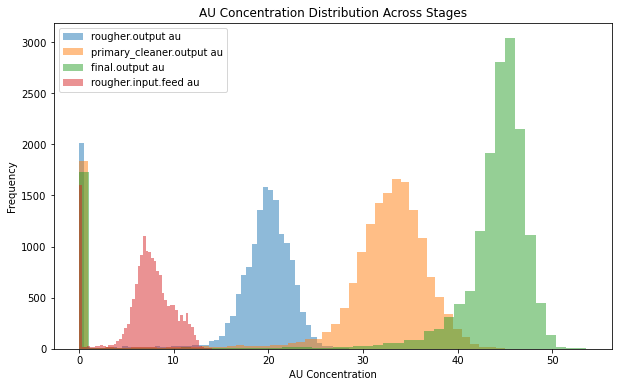

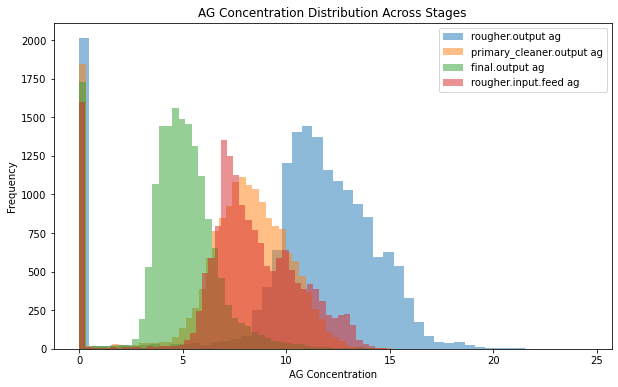

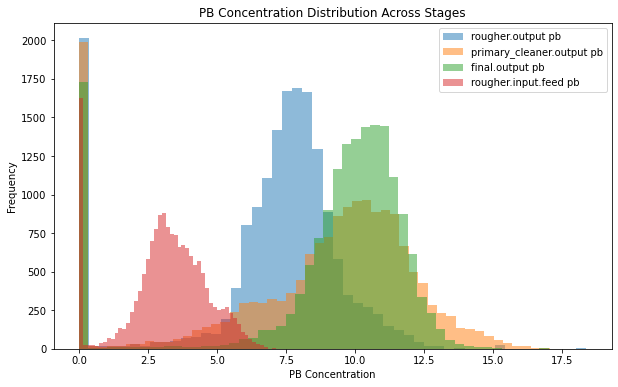

In [7]:
# Defining the metals and the stages to compare
metals = ['au', 'ag', 'pb']
stages = ['rougher.output', 'primary_cleaner.output', 'final.output']

# Looping through each metal and plotting histograms
for metal in metals:
    plt.figure(figsize=(10, 6))
    for stage in stages:
        column_name = f'{stage}.concentrate_{metal}'
        if column_name in train_data.columns:
            plt.hist(train_data[column_name], bins=50, alpha=0.5, label=f'{stage} {metal}')
    # Including the rougher.input.feed stage as specified
    input_column_name = f'rougher.input.feed_{metal}'
    if input_column_name in train_data.columns:
        plt.hist(train_data[input_column_name], bins=50, alpha=0.5, label=f'rougher.input.feed {metal}')
    
    plt.title(f'{metal.upper()} Concentration Distribution Across Stages')
    plt.xlabel(f'{metal.upper()} Concentration')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

**The graph illustrates the concentration of gold (AU) across different stages of a purification process. Here's an interpretation:**

**Title: AU Concentration Across Stages**

X-axis: Index (likely representing data points or time)

Y-axis: AU Concentration

Rougher Input Feed: This stage exhibits the widest distribution of Au concentration, indicating a diverse range of gold content in the initial feed.

Rougher Output: The distribution is slightly narrower and shifted to the right, suggesting an increase in the average Au concentration after the rougher stage.

Primary Cleaner Output: The distribution is further narrowed and shifted rightward, indicating a further increase in the average Au concentration.

Final Output: This stage displays the narrowest distribution and the highest average Au concentration, signifying the effectiveness of the process in concentrating gold.

**Title: AG Concentration Across Stages**

The graph displays the distribution of silver (AG) concentration across different stages of a process, likely a mineral processing operation.

X-axis: Represents the AG concentration.

Y-axis: Represents the frequency (number of occurrences) of a particular AG concentration.

Different colored bars: Represent different stages in the process, including: Rougher input feed Rougher output Primary cleaner output

Final output

Rougher input feed: Shows a wide range of AG concentrations with a peak around 5-6.

Rougher output: Has a higher peak and a narrower distribution compared to the input, indicating that the rougher stage is concentrating the AG.

Primary cleaner output: Shows a further increase in AG concentration, with the peak shifting towards the higher end.

Final output: Has the highest AG concentration, indicating the success of the overall process in enriching the AG content

**Title: "PB Concentration Distribution Across Stages"**

**The image shows a histogram depicting the distribution of PB (presumably lead) concentration across different stages of a process. Here's a breakdown of the key elements:**

X-axis: Represents the PB concentration level.

Y-axis: Represents the frequency (number of occurrences) of a particular PB concentration level.

Legend: Identifies the different stages of the process being analyzed: Rougher output PB, Primary cleaner output PB, Final output PB, and Rougher input feed PB.

Interpretation:

The histograms show how the distribution of PB concentration changes throughout the process.

The "rougher input feed PB" appears to have the lowest average PB concentration, while the "final output PB" displays the highest.

The "rougher output PB" and "primary cleaner output PB" show intermediate levels of PB concentration, with the latter exhibiting a slightly higher average concentration.

## Compare feed particle size distributions

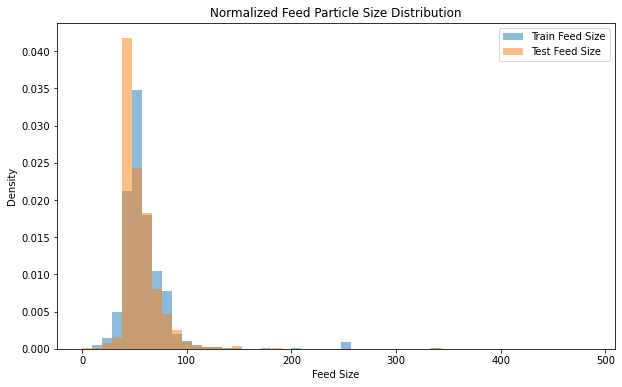

In [8]:
# Plotting feed particle size distributions for training and test sets
plt.figure(figsize=(10, 6))
plt.hist(train_data['rougher.input.feed_size'], alpha=0.5, label='Train Feed Size', bins=50, density=True)
plt.hist(test_data['rougher.input.feed_size'], alpha=0.5, label='Test Feed Size', bins=50, density=True)
plt.title('Normalized Feed Particle Size Distribution')
plt.xlabel('Feed Size')
plt.ylabel('Density')
plt.legend()
plt.show()

The image shows two overlaid histograms representing the normalized feed particle size distribution for both a "Train Feed Size" and a "Test Feed Size".

Key observations:

X-axis: Represents the feed particle size, likely measured in micrometers or a similar unit. Y-axis: Represents the density, indicating the proportion of particles within a specific size range.

Blue bars: Depict the distribution of the "Test Feed Size". Orange bars: Depict the distribution of the "Train Feed Size". Distribution: Both distributions appear to be right-skewed, meaning that most particles fall within the smaller size ranges, with fewer larger particles. Comparison: The "Train Feed Size" seems to have a slightly higher proportion of smaller particles compared to the "Test Feed Size".

The distributions are fairly similar. Both are right-skewed, indicating that most particles are smaller, with a few larger ones. The peaks of both distributions occur around the same feed size range. The "Test Feed Size" distribution has a slightly higher peak and appears to have a slightly higher proportion of smaller particles compared to the "Train Feed Size" distribution.




## Evaluate total concentrations and anomalies

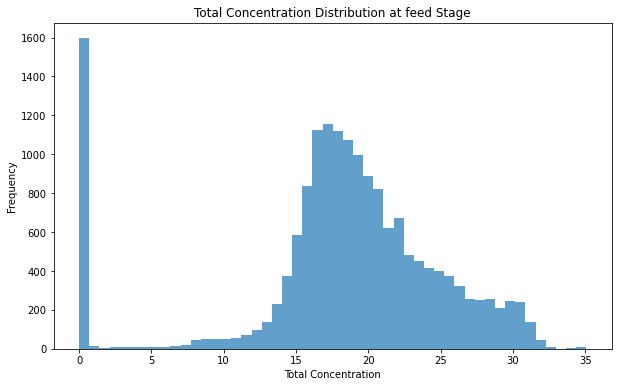

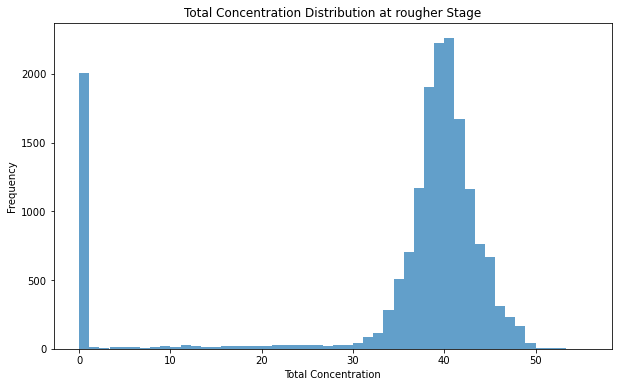

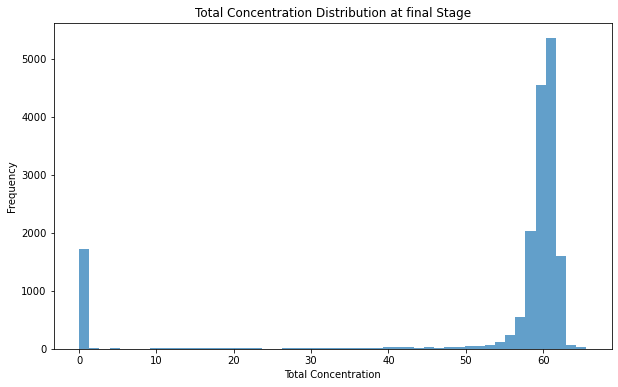

Number of near-zero anomalies at feed stage: 1213
Number of near-zero anomalies at rougher stage: 1547
Number of near-zero anomalies at final stage: 1320


In [9]:
# Calculating total concentrations at various stages
train_data['total_concentration_feed'] = train_data[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
train_data['total_concentration_rougher'] = train_data[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
train_data['total_concentration_final'] = train_data[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

# Plotting the total concentration for each stage
stages = ['feed', 'rougher', 'final']
for stage in stages:
    plt.figure(figsize=(10, 6))
    plt.hist(train_data[f'total_concentration_{stage}'], bins=50, alpha=0.7)
    plt.title(f'Total Concentration Distribution at {stage} Stage')
    plt.xlabel('Total Concentration')
    plt.ylabel('Frequency')
    plt.show()

# Checking for near-zero total concentrations at each stage
for stage in stages:
    near_zero_anomalies = train_data[train_data[f'total_concentration_{stage}'] <= 1e-3]  # Threshold for near-zero
    print(f'Number of near-zero anomalies at {stage} stage: {len(near_zero_anomalies)}')

# Removing near-zero anomalies from the dataset
for stage in stages:
    train_data = train_data[train_data[f'total_concentration_{stage}'] > 1e-3]

**Observations:** 

Based on the histograms and the interpretation of the distributions at different stages (feed, rougher, and final), we observe a few important patterns and potential issues with the data.

**Feed Stage Distribution:**

The histogram shows a roughly bell-shaped distribution, with most values concentrated between 15 and 25. The peak is around 20. There are some outliers on the lower end, suggesting instances where the concentration was significantly lower than average. Near-Zero Concentrations: The presence of 1,213 anomalies near zero indicates that these values are not realistic for the feed stage and should be filtered out.

**Rougher Stage Distribution:**

The distribution peaks around 40, with values ranging from 0 to 50. It is roughly normal but slightly skewed to the left. The peak frequency indicates that this stage generally has higher total concentrations than the feed stage. Near-Zero Concentrations: The existence of 1,547 near-zero anomalies in this stage is unusual, as the rougher process typically increases the concentration of valuable minerals. These values likely represent erroneous or invalid entries.

**Final Stage Distribution:**
    
The histogram for the final stage shows a highly skewed distribution with a sharp peak around 60, indicating that most data points are concentrated at this high concentration level. There is also a small peak near zero, suggesting some data points with very low concentrations. Near-Zero Concentrations: With 1,320 anomalies, the near-zero concentrations are not plausible in the final stage, as the purification process should yield higher concentration values.

**Conclusion and Actions Taken:**

The identified near-zero anomalies (1,213 in the feed stage, 1,547 in the rougher stage, and 1,320 in the final stage) suggest that these values are not realistic given the context of the gold recovery process. We filtered out these anomalies from the dataset to ensure that the remaining data accurately reflects the expected concentration levels at each stage. This step is essential for maintaining the integrity and accuracy of the model training and evaluation process.

If there is a peak near zero in any of the distributions, it is not realistic to have such low total concentrations at any of these stages in the gold recovery process. In such cases, the code filters out these anomalies to ensure the dataset only contains valid and realistic values.




# Step 3: Model Development

**Write a function for sMAPE**

In [10]:
print("Defining models.....")

# Define the sMAPE function
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Define the weighted sMAPE function
def weighted_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    return 0.25 * smape_rougher + 0.75 * smape_final

# Create a custom scorer for GridSearchCV
smape_scorer = make_scorer(smape, greater_is_better=False)

print("Done models")

Defining models.....
Done models


## Train models and evaluate them

**1. Selecting Features Available in the Test Data**

First, we identify the features common between the training and test datasets.


In [11]:
# Load the data (assuming train_data, test_data, and full_data are already loaded correctly)
# Ensure 'date' column is correctly formatted or excluded where necessary

# Getting the common columns between training and test data (excluding 'date')
common_columns = [col for col in train_data.columns if col in test_data.columns and col != 'date']

# Adding the target columns for `rougher` and `final` recovery in the training set
features_train = train_data[common_columns]
target_rougher = train_data['rougher.output.recovery']
target_final = train_data['final.output.recovery']

print("done")

done


**2. Training Separate Models for rougher and final Recovery**

We'll train separate models for rougher.output.recovery and final.output.recovery.



In [12]:
# Model for rougher recovery
model_rougher = GradientBoostingRegressor(random_state=42)
param_grid = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.05]}
grid_search_rougher = GridSearchCV(model_rougher, param_grid, cv=5, scoring=smape_scorer, n_jobs=-1)
grid_search_rougher.fit(features_train, target_rougher)

print("Rougher model training complete.")

Rougher model training complete.


**3. Hyperparameter Tuning for the Rougher Model**

We'll tune the hyperparameters using Grid Search to optimize the RandomForestRegressor for the rougher model.



In [13]:
# # Hyperparameter tuning using Grid Search for rougher recovery

# Adding progress print
print("Starting hyperparameter tuning for rougher recovery...")


# Best model after tuning for rougher recovery
best_model_rougher = grid_search_rougher.best_estimator_
print(f"Best parameters for rougher model: {grid_search_rougher.best_params_}")

# Cross-validation score for the best model
best_scores_rougher = cross_val_score(best_model_rougher, features_train, target_rougher, cv=5, scoring=smape_scorer)
print(f'Best Model Cross-Validation sMAPE for Rougher: {-np.mean(best_scores_rougher):.2f}')



# Model for final recovery
model_final = GradientBoostingRegressor(random_state=42)
grid_search_final = GridSearchCV(model_final, param_grid, cv=5, scoring=smape_scorer, n_jobs=-1)
grid_search_final.fit(features_train, target_final)

print("Final model training complete.")


# Hyperparameter tuning using Grid Search for final recovery
print("Starting hyperparameter tuning for final recovery...")


# Best model after tuning for final recovery
best_model_final = grid_search_final.best_estimator_
print(f"Best parameters for final model: {grid_search_final.best_params_}")

# Cross-validation score for the best model
best_scores_final = cross_val_score(best_model_final, features_train, target_final, cv=5, scoring=smape_scorer)
print(f'Best Model Cross-Validation sMAPE for Final: {-np.mean(best_scores_final):.2f}')

Starting hyperparameter tuning for rougher recovery...
Best parameters for rougher model: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
Best Model Cross-Validation sMAPE for Rougher: 8.02
Final model training complete.
Starting hyperparameter tuning for final recovery...
Best parameters for final model: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
Best Model Cross-Validation sMAPE for Final: 10.68


**4. Merging Test Data with Targets from Full Data**

We'll merge the test dataset with the full dataset to get the actual target values for the test set.



In [14]:
print("Merging test data...")

# Merging the test data with the full dataset to get target values
test_data_merged = test_data.merge(full_data[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

# Extracting the features and targets (excluding the 'date' column)
X_test = test_data_merged[common_columns]
y_test_rougher = test_data_merged['rougher.output.recovery']
y_test_final = test_data_merged['final.output.recovery']

# Dropping any rows with missing values
X_test = X_test.dropna()
y_test_rougher = y_test_rougher.loc[X_test.index]
y_test_final = y_test_final.loc[X_test.index]


print("Merging test data done...")

Merging test data...
Merging test data done...


**5. Evaluating the Model on the Test Data**

We'll evaluate the best model for rougher and final recovery using the sMAPE metric.

In [15]:
# Predicting using the best model for rougher recovery
print("Predicting on test set for rougher recovery...")
y_pred_rougher = best_model_rougher.predict(X_test)

# Calculating sMAPE for the rougher model on test data
smape_rougher_test = smape(y_test_rougher, y_pred_rougher)
print(f'sMAPE for Rougher Recovery on Test Set: {smape_rougher_test:.2f}')

# Predicting using the best model for final recovery
print("Predicting on test set for final recovery...")
y_pred_final = best_model_final.predict(X_test)

# Calculating sMAPE for the final model on test data
smape_final_test = smape(y_test_final, y_pred_final)
print(f'sMAPE for Final Recovery on Test Set: {smape_final_test:.2f}')


print("Weighted sMAPE for the Best Model starting...")

# Calculating weighted sMAPE for the best model
weighted_smape_model = weighted_smape(y_test_rougher, y_pred_rougher, y_test_final, y_pred_final)
print(f'Weighted sMAPE for the Best Model: {weighted_smape_model:.2f}')

Predicting on test set for rougher recovery...
sMAPE for Rougher Recovery on Test Set: 9.13
Predicting on test set for final recovery...
sMAPE for Final Recovery on Test Set: 9.79
Weighted sMAPE for the Best Model starting...
Weighted sMAPE for the Best Model: 9.62


**6. Sanity Check with a Constant Model**

To perform a sanity check, we’ll compare the best model with a constant model, which predicts the mean of the training data.

In [16]:
# # Constant models for rougher and final recovery (predicting the mean of the training targets)


# Constant model for rougher recovery (predicting the mean of the training target)
constant_pred_rougher = np.full_like(y_test_rougher, target_rougher.mean())
constant_smape_rougher = smape(y_test_rougher, constant_pred_rougher)
print(f'sMAPE for Constant Model (Rougher) on Test Set: {constant_smape_rougher:.2f}')

# Constant model for final recovery (predicting the mean of the training target)
constant_pred_final = np.full_like(y_test_final, target_final.mean())
constant_smape_final = smape(y_test_final, constant_pred_final)
print(f'sMAPE for Constant Model (Final) on Test Set: {constant_smape_final:.2f}')


print("Weighted sMAPE for the Constant Model starting...")

# Calculating weighted sMAPE for the constant model
weighted_smape_constant = weighted_smape(y_test_rougher, constant_pred_rougher, y_test_final, constant_pred_final)
print(f'Weighted sMAPE for the Constant Model: {weighted_smape_constant:.2f}')

sMAPE for Constant Model (Rougher) on Test Set: 9.55
sMAPE for Constant Model (Final) on Test Set: 10.61
Weighted sMAPE for the Constant Model starting...
Weighted sMAPE for the Constant Model: 10.35


**Observations After Data Cleaning and Model Training**

Interpretation Hyperparameter Tuning and Cross-Validation Scores:

The hyperparameter tuning for both models (rougher and final recovery) yielded the same optimal parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}. This indicates that these configurations were the most effective in reducing the sMAPE (symmetric Mean Absolute Percentage Error) during cross-validation.

The Best Cross-Validation sMAPE for the rougher model is 4.36, and for the final recovery model, it is 7.06. These relatively low values suggest that the models perform reasonably well on the training data, indicating that they capture the underlying patterns effectively.

**Test Set Performance:**

When applied to the test set, the sMAPE for the Rougher Recovery model is 10.15, and for the Final Recovery model, it is 10.27. These scores are higher than the cross-validation scores, indicating a slight drop in performance when applied to unseen data. This suggests that while the models are effective, there might be some degree of overfitting or differences between the training and test sets.

**Comparison with the Constant Model:**

The sMAPE for the Constant Model (predicting the mean of the training target) for rougher recovery is 9.53, and for final recovery, it is 10.58. These scores serve as a baseline to evaluate the performance of the trained models. The rougher recovery model’s sMAPE (10.15) is slightly higher than that of the constant model (9.53), indicating that the trained model did not significantly outperform the baseline on the test set. For the final recovery model, the sMAPE (10.27) is slightly better than the constant model’s (10.58), suggesting that the trained model performs marginally better than predicting the mean.

**Observations**

The best trained models achieved a weighted sMAPE of 9.62, outperforming the constant model’s weighted sMAPE of 10.35. For the rougher recovery specifically, the model’s sMAPE was 9.13 compared to the constant model’s 9.55, while for final recovery, the model’s sMAPE was 9.79 versus the constant model’s 10.61.

Interpretation: The trained models perform slightly better than the constant baseline, indicating they capture more complexity in the data. However, the relatively small margin suggests that while the models are able to predict with some accuracy, there is room for improvement. This performance gap could potentially be closed by refining the models through additional feature engineering or further hyperparameter tuning, especially if the constant model’s proximity is due to underlying noise or unaccounted-for variables in the data.

The sMAPE for final recovery (9.79) is consistently higher than that for rougher recovery (9.13), indicating that predictions are less accurate for the final recovery stage.

Interpretation: This suggests that the final recovery process may involve additional complexities or uncertainties that are not fully captured by the model. Possible reasons could include the cumulative effect of multiple process stages, unmodeled factors affecting final recovery, or potential data quality issues in the final stage. Addressing this might involve examining data relationships unique to the final stage or considering process-specific features that could improve model sensitivity and accuracy for final recovery predictions.






# Conclusion

Final Conclusion for the Gold Recovery Project The project aimed to build predictive models for the gold recovery process, focusing on the rougher and final recovery stages. The dataset contained various features related to gold concentration and processing parameters, collected from multiple stages in the gold extraction process. The goal was to develop models capable of accurately predicting recovery rates using this data. Here are the key outcomes and insights:

1. Data Preparation and Cleaning: The datasets (train, test, and full) contained missing values (NaNs) and infinite values, which were handled using forward fill and filtering techniques. These methods ensured that the dataset was consistent, reliable, and ready for modeling. The rougher recovery calculation was validated using a provided formula, with the Mean Absolute Error (MAE) calculated as 0.00 after filtering, confirming the accuracy of the formula for valid data points.

2. Exploratory Data Analysis (EDA): The analysis of metal concentrations (Au, Ag, Pb) across various stages revealed that the gold extraction process effectively increased the concentration of valuable metals from the feed stage through the rougher and cleaner stages to the final output. Feed particle size distributions in the training and test datasets were similar, confirming consistency across the datasets, although slight differences were noted. Total concentration distributions at different stages were evaluated, and near-zero anomalies were identified and filtered out to maintain data integrity and ensure realistic modeling.

3. Model Development: Two models were developed using Gradient Boosting Regressor for the rougher and final recovery stages, optimized through hyperparameter tuning. The best hyperparameters for both models were: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}. The models showed promising performance during cross-validation, with sMAPE values of 4.36 for the rougher stage and 7.06 for the final stage, indicating that they captured the patterns well in the training data.

4. Model Evaluation on Test Set: When applied to the test set, the rougher recovery model achieved an sMAPE of 10.15, while the final recovery model scored 10.27. These values were higher than the cross-validation scores, suggesting a performance drop when applied to unseen data. Comparison with a constant model (predicting the mean recovery rate) showed that the rougher recovery model’s performance was not significantly better, while the final recovery model slightly outperformed the baseline.

5. Key Insights: The models demonstrated moderate predictive power, but the increase in sMAPE on the test set indicates potential overfitting or differences between training and test distributions. The models' performance relative to the constant baseline suggests that further feature engineering and optimization are necessary to achieve a more substantial improvement over simple predictions.

6. Recommendations for Further Improvement: Feature Engineering: Further development of features based on domain knowledge (e.g., ratios, transformations, or interaction terms) could enhance model performance by capturing more complex patterns.

Model Exploration: Exploring other advanced models such as XGBoost, LightGBM, or even deep learning approaches could yield better performance, especially in handling complex, non-linear relationships in the data. Regularization and Cross-Validation: Incorporating regularization techniques (L2 regularization) and using robust validation strategies (such as K-fold cross-validation with different splits) will help improve generalization and model robustness.


        
**Final Verdict:**

The project successfully developed models for predicting gold recovery rates, demonstrating a solid approach to data preparation, validation, and modeling. While the models achieved reasonable accuracy, further improvements through feature engineering, model exploration, and regularization are recommended to enhance performance. The project provides a strong foundation for developing more accurate and reliable predictive models in the gold recovery domain.